In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.preprocessing import FourierFeaturizer

from common_functions import *

def plot_forecast(test, forecast, date_col='DateTime', true_label='y', predicted_label='yhat'):
    plt.figure(figsize=(10,6))
    plt.plot(test[date_col], test[true_label], label='Actual')
    plt.plot(test[date_col], forecast[predicted_label], label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(true_label)
    plt.title('Actual vs Predicted ' + true_label)
    plt.show()


def train_ARIMA(train_data, x_train_transformed, order, seasonal_order):
    model = ARIMA(train_data, exog=x_train_transformed, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    return model_fit

def forecast_ARIMA(model_fit, test_size, x_test_transformed):
    forecast = model_fit.forecast(test_size, exog=x_test_transformed)
    return forecast


def split_data(df, offset, train_size, test_size):
    """
    Split the data into train and test sets.

    Parameters:
    df (DataFrame): The input dataframe containing the time series data.
    offset (int): The number of days to offset the start of the train data from the beginning of the dataframe.
    train_size (int): The number of months to include in the train data.
    test_size (int): The number of days to include in the test data.

    Returns:
    train_data (DataFrame): The train data.
    test_data (DataFrame): The test data.
    start_date (Timestamp): The start date of the train data.
    slice_date (Timestamp): The end date of the train data.
    end_date (Timestamp): The end date of the test data.
    """
    train_data = df[(df.DateTime >= df.DateTime.min() + pd.DateOffset(days=offset)) & (df.DateTime <= df.DateTime.min() + pd.DateOffset(days=offset) + pd.DateOffset(months=train_size))]

    # If there is no number_of_test_values left in the df to the end, then train and test should be none
    if train_data.DateTime.max() + pd.DateOffset(days=test_size) > df.DateTime.max():
        return None, None, None, None, None

    test_data = df[(df.DateTime > train_data.DateTime.max()) & (df.DateTime <= train_data.DateTime.max() + pd.DateOffset(days=test_size))]

    start_date, slice_date, end_date = train_data.DateTime.min(), train_data.DateTime.max(), test_data.DateTime.max()

    return train_data, test_data, start_date, slice_date, end_date


In [3]:
# Write experiment data to file
dir_name = 'Results'
file_name = 'ARIMA_experiment_results.csv'
results_file_path = os.path.join(dir_name, file_name)

# Create the directory if it doesn't exist
os.makedirs(dir_name, exist_ok=True)

# Experiment parameters
# train_size represents the number of months to be used for training (e.g. 4*12 is 4 years, 6 is 0.5 years)
# test_sizes represents the number of days to be used for testing (e.g. 4*7 is 4 weeks)
experiment_cases = [
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},

    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},

    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]}
]

# *All experiment results have been written to file, comment out the following lines only if you want to re-run the experiments
# for experiment_case in experiment_cases:
#     input_dir = experiment_case['input_dir']
#     filename = experiment_case['filename']
#     label = experiment_case['label']
#     train_size = experiment_case['train_size']
#     test_sizes = experiment_case['test_sizes']

#     if 'hourly' in filename:
#         m=24*365
#     elif 'daily' in filename:
#         m=365

#     # Load the CSV file
#     df = pd.read_csv(os.path.join(input_dir,filename))
#     df.DateTime = pd.to_datetime(df.DateTime)


#     print(f'\nRunning experiment for {filename} with label {label}:\n')
#     for test_size in test_sizes:
#         offset = 0 # start from the beginning of the dataframe
#         while True:
#             train_data, test_data, start_date, slice_date, end_date = split_data(df, offset, train_size, test_size)

#             if train_data is None or test_data is None:
#                 print(f'No more data for test size {test_size} days')
#                 break

#             # Fourier transform
#             fourier_featurizer = FourierFeaturizer(m, 2)
#             y_train_transformed, x_train_transformed = fourier_featurizer.fit_transform(train_data.AQI.values.reshape(-1,1))
#             y_test_transformed, x_test_transformed = fourier_featurizer.transform(test_data.AQI.values.reshape(-1,1), n_periods=len(test_data))

#             if offset == 0:
#                 # Find best parameters only first time to speed up the process
#                 best_param_model = pm.auto_arima(y_train_transformed, exogenous=x_train_transformed, stationary=False, seasonal=False, stepwise=True)
#                 order = best_param_model.get_params()['order']
#                 seasonal_order = best_param_model.get_params()['seasonal_order']

#             model_fit = train_ARIMA(y_train_transformed, x_train_transformed, order, seasonal_order)
#             forecast = forecast_ARIMA(model_fit, len(test_data), x_test_transformed)

#             mae = mean_absolute_error(y_test_transformed, forecast)
#             rmse = np.sqrt(mean_squared_error(y_test_transformed, forecast))
#             r2 = r2_score(y_test_transformed, forecast)
#             smape = calculate_smape(y_test_transformed.reshape(-1), forecast)

#             # Write results to file
#             # Prepare data for CSV
#             data = {
#                 'DateTime of experiment': [datetime.datetime.now()],
#                 'Dataset used': [filename],
#                 'Label predicted': [label],
#                 'Training data from': [start_date],
#                 'Training data to': [slice_date],
#                 'Testing data from': [slice_date],
#                 'Testing data to': [end_date],
#                 'Test size': [len(test_data[label])],
#                 'Test Predictions': [forecast.tolist()],
#                 'Test Data': [y_test_transformed.reshape(-1).tolist()],
#                 'Order': [order],
#                 'Seasonal Order': [seasonal_order],
#                 'RMSE': [rmse],
#                 'MAE': [mae],
#                 'R2': [r2],
#                 'SMAPE': [smape]
#             }

#             # print finished iteration
#             print(f'Finished iteration offset={offset} days train_size={train_size} months test_size={test_size} days\n')

#             offset += 7 # move train+test window forward by 7 days for next iteration

#             # Convert to DataFrame
#             df_results = pd.DataFrame(data)

#             # Write DataFrame to CSV
#             df_results.to_csv(results_file_path, mode='a', header=not os.path.exists(results_file_path), index=False)


Results for dataset_aqi_daily.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 19.00428639167124
RMSE: 30.71611663304419
R2: 0.5197730988643157
SMAPE: 22.96326911686743
Errors for 7 days:
MAE: 26.430705096648108
RMSE: 35.38180996335106
R2: 0.45682243698685643
SMAPE: 32.16359479458841
Errors for 14 days:
MAE: 26.077885373989524
RMSE: 35.02649809195681
R2: 0.4629352881017397
SMAPE: 31.52816952411644
Errors for 28 days:
MAE: 25.737902436963036
RMSE: 35.115506789700866
R2: 0.4690148667425452
SMAPE: 31.130604856972145


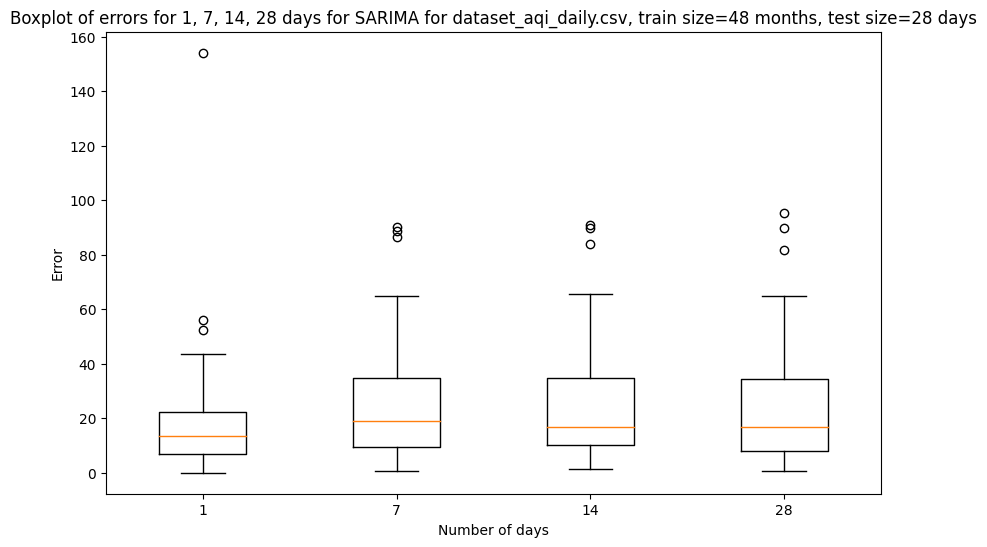


Results for dataset_aqi_hourly.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 25.637256099516232
RMSE: 37.349517080458185
R2: 0.4393394783414657
SMAPE: 36.070161776030325
Errors for 7 days:
MAE: 40.44902812292674
RMSE: 54.118519661179
R2: 0.10902258900781969
SMAPE: 55.214175103719555
Errors for 14 days:
MAE: 45.26747511166442
RMSE: 61.756807177968035
R2: -0.1709409986735393
SMAPE: 59.67400737202679
Errors for 28 days:
MAE: 48.20756559759439
RMSE: 62.73596227291482
R2: -0.19489914648486262
SMAPE: 71.11105177176579


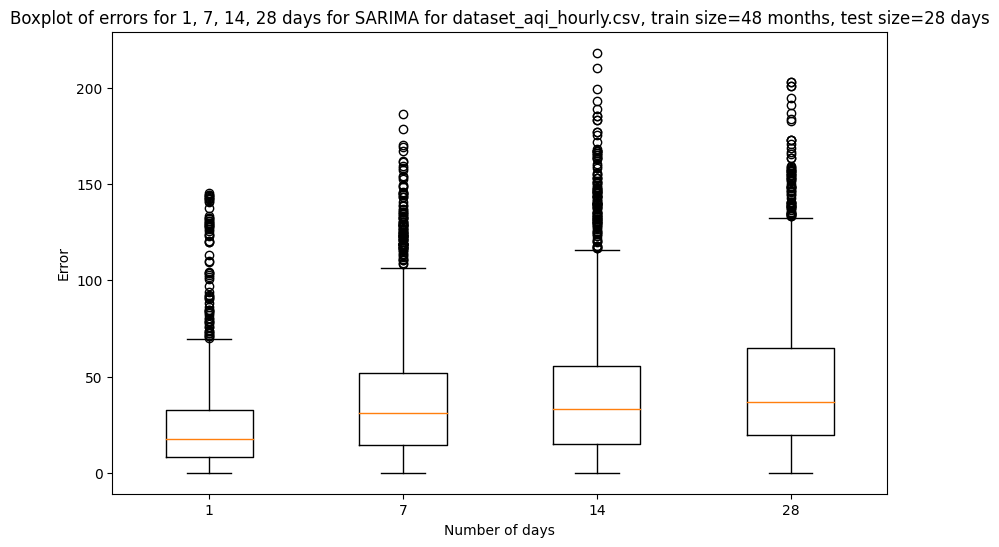


Results for dataset_aqi_daily_filled_with_neighbors.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 18.98692274122219
RMSE: 30.704851464967167
R2: 0.5201252817127766
SMAPE: 22.932727640819067
Errors for 7 days:
MAE: 26.492481315739845
RMSE: 35.43463902277336
R2: 0.4551991744885622
SMAPE: 32.236436575138605
Errors for 14 days:
MAE: 26.098988323621686
RMSE: 35.05276556701286
R2: 0.46212946254341924
SMAPE: 31.525709081383432
Errors for 28 days:
MAE: 25.81572786077518
RMSE: 35.159379101725676
R2: 0.46768724256891525
SMAPE: 31.241130723580167


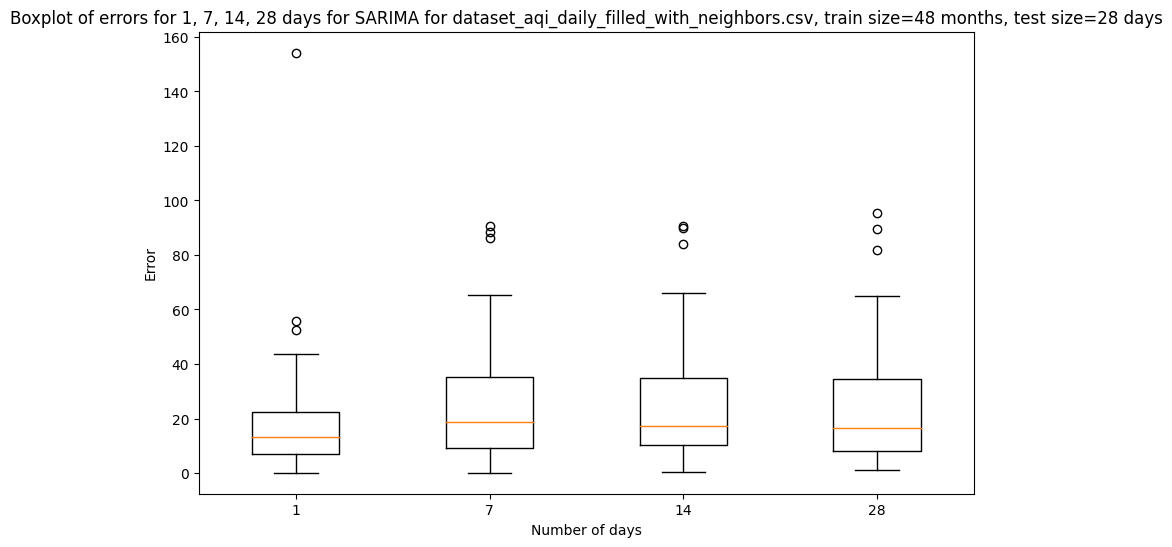


Results for dataset_aqi_hourly_filled_with_neighbors.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 25.679510088754988
RMSE: 37.326583653269964
R2: 0.4427148004553333
SMAPE: 36.198981882568845
Errors for 7 days:
MAE: 40.620295589855246
RMSE: 54.2181802800917
R2: 0.10590966737462548
SMAPE: 55.45106269535946
Errors for 14 days:
MAE: 45.137932964058265
RMSE: 61.58318203092867
R2: -0.16413231047491372
SMAPE: 59.420297791649446
Errors for 28 days:
MAE: 48.251830157354576
RMSE: 62.550371973751446
R2: -0.1876226034507935
SMAPE: 71.21326599205287


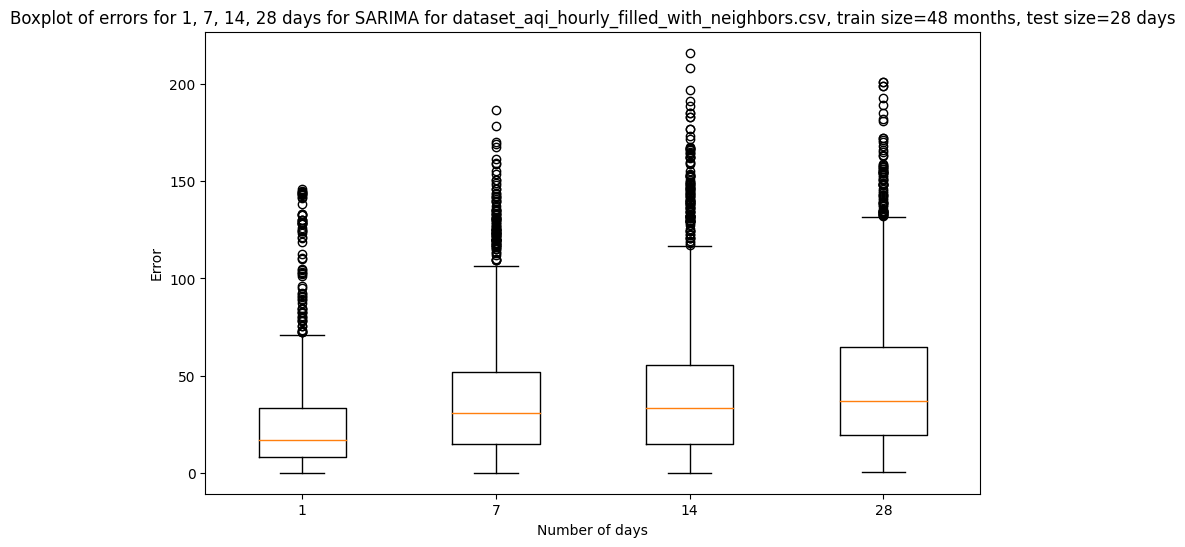


Results for dataset_aqi_daily.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 19.799561301035233
RMSE: 28.759247076849334
R2: 0.7198875868417354
SMAPE: 23.77670488827954
Errors for 7 days:
MAE: 26.389093111423488
RMSE: 41.12401931866307
R2: 0.3586581289948477
SMAPE: 29.0796183998272
Errors for 14 days:
MAE: 27.63772762277454
RMSE: 42.8367385412216
R2: 0.30483776455592093
SMAPE: 29.949465305854257
Errors for 28 days:
MAE: 28.934609450170104
RMSE: 44.572496864935324
R2: 0.24819709578682903
SMAPE: 31.614851131142675


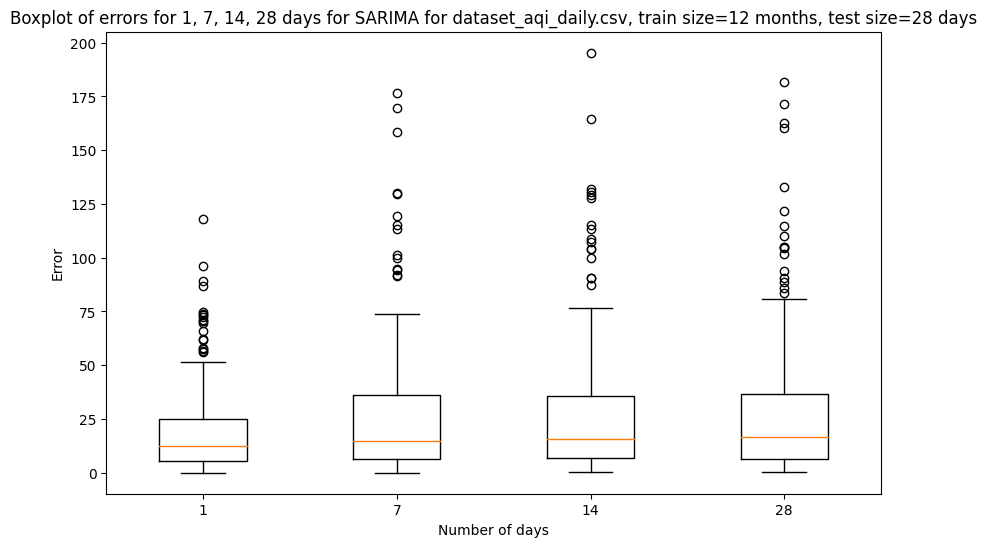


Results for dataset_aqi_hourly.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 26.268392499924378
RMSE: 40.97824913639503
R2: 0.5209776592554696
SMAPE: 34.920119173940996
Errors for 7 days:
MAE: 38.232490771799746
RMSE: 56.509213410759614
R2: -0.10995246315273088
SMAPE: 48.87198961741749
Errors for 14 days:
MAE: 45.513624135278974
RMSE: 65.88085721901213
R2: -0.5174417305060515
SMAPE: 57.823279046732345
Errors for 28 days:
MAE: 50.66209802455161
RMSE: 73.5244915537477
R2: -0.8754779386372433
SMAPE: 65.70027154985614


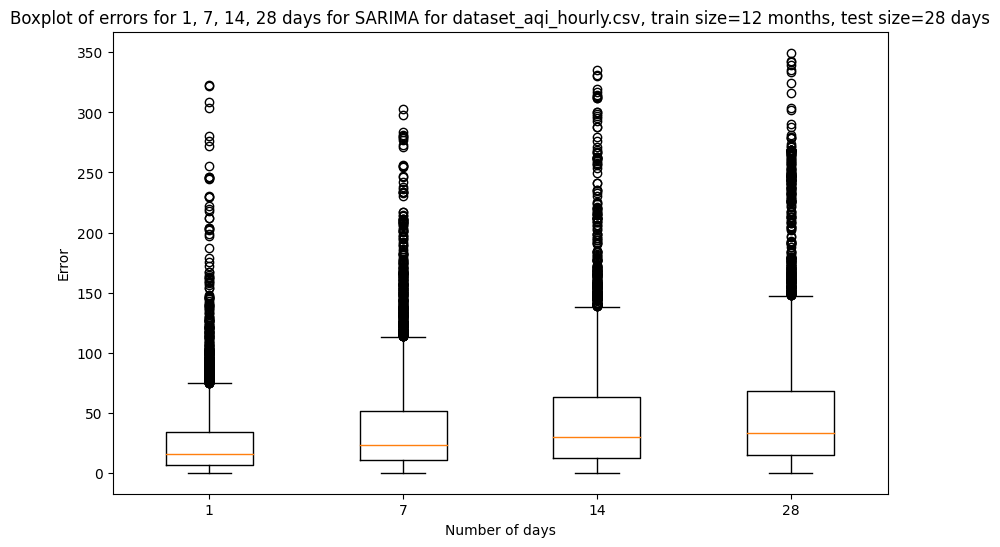


Results for dataset_aqi_daily_filled_with_neighbors.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 19.701492245628206
RMSE: 28.63708173417803
R2: 0.7221366050709765
SMAPE: 23.697495006222624
Errors for 7 days:
MAE: 26.586636770654756
RMSE: 41.31226827519542
R2: 0.3529392288080959
SMAPE: 29.34971097592838
Errors for 14 days:
MAE: 28.154372749929426
RMSE: 43.3837369422114
R2: 0.28715389042545625
SMAPE: 30.634218495370206
Errors for 28 days:
MAE: 29.436746480398476
RMSE: 45.15629525442576
R2: 0.228290535915453
SMAPE: 32.44646155687361


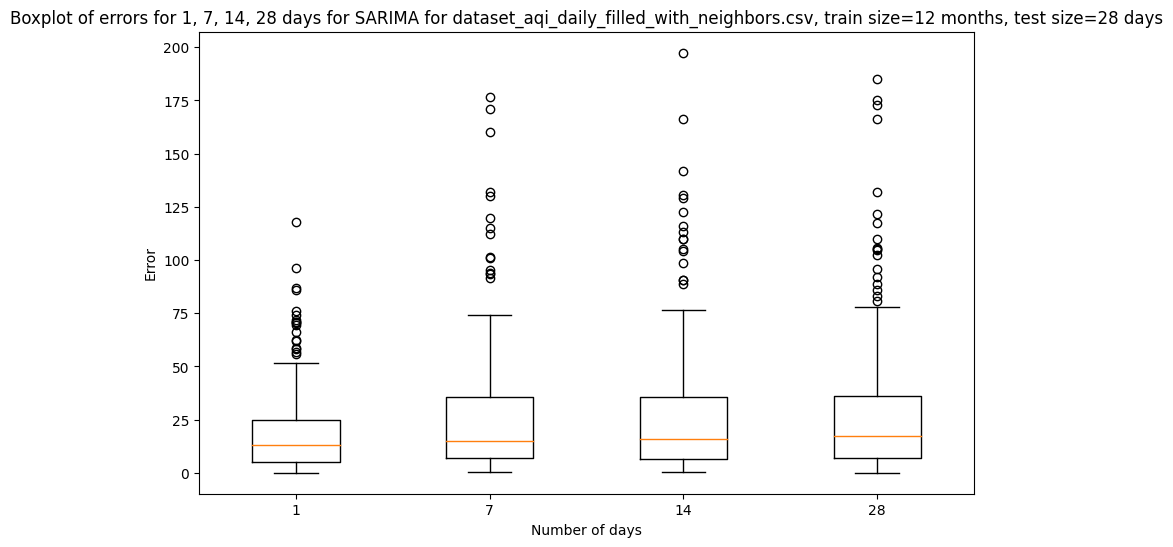


Results for dataset_aqi_hourly_filled_with_neighbors.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 25.52063185600362
RMSE: 37.87172052764964
R2: 0.5916156037808966
SMAPE: 34.015112440318745
Errors for 7 days:
MAE: 38.78217419593377
RMSE: 58.12660702488763
R2: -0.1669783877036981
SMAPE: 48.52229022896599
Errors for 14 days:
MAE: 46.384115939495125
RMSE: 67.67972859710044
R2: -0.591145853809748
SMAPE: 57.57566307327643
Errors for 28 days:
MAE: 51.62504181042709
RMSE: 75.0363346292205
R2: -0.9415054049043017
SMAPE: 66.12176725081987


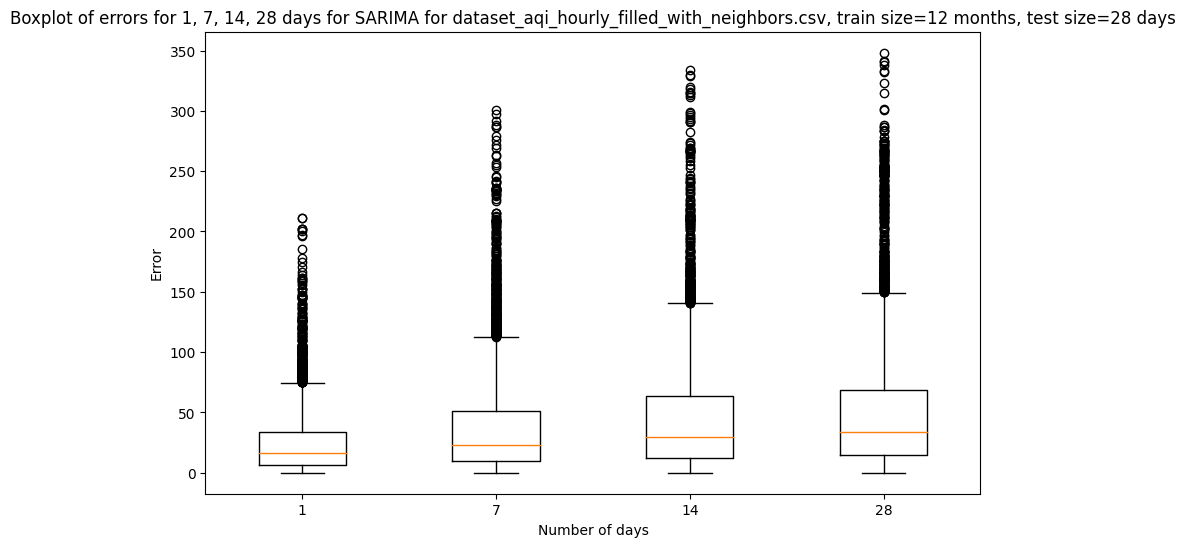


Results for dataset_aqi_daily.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 25.310323246590112
RMSE: 37.59267355645529
R2: 0.5747108082766383
SMAPE: 28.122818238706085
Errors for 7 days:
MAE: 39.544650293762416
RMSE: 52.76329818701674
R2: 0.022528939332318587
SMAPE: 52.45238101035013
Errors for 14 days:
MAE: 53.32873007089051
RMSE: 70.93942678261581
R2: -0.6210119195104036
SMAPE: 66.0772592565433
Errors for 28 days:
MAE: 76.8215908067618
RMSE: 104.3573940607658
R2: -2.4593642418000794
SMAPE: 87.02617456402955


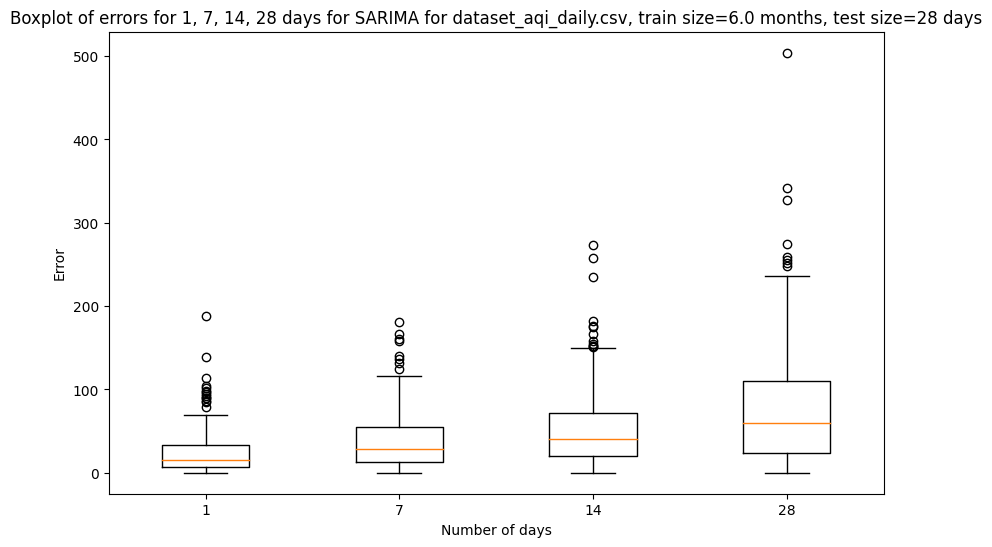


Results for dataset_aqi_hourly.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 27.246599263786322
RMSE: 39.31710512340775
R2: 0.5820322149329258
SMAPE: 33.92692330297257
Errors for 7 days:
MAE: 45.46657059649231
RMSE: 60.52902775949808
R2: -0.06791337320961821
SMAPE: 62.99958300366777
Errors for 14 days:
MAE: 61.5423966917586
RMSE: 83.92101524649263
R2: -0.9177897760251565
SMAPE: 84.93633819247324
Errors for 28 days:
MAE: 99.34907033636553
RMSE: 129.0974921235379
R2: -3.844307605449284
SMAPE: 114.73016771697428


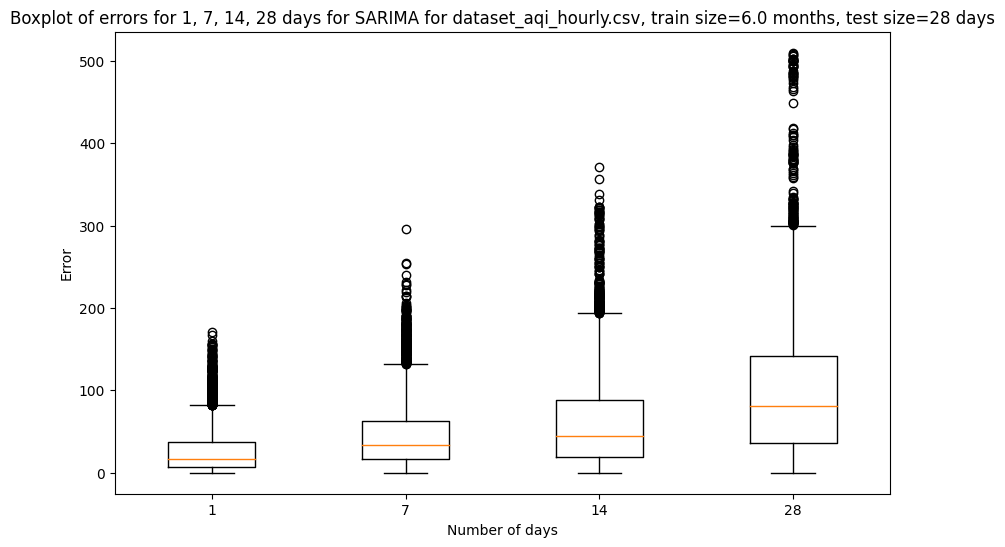


Results for dataset_aqi_daily_filled_with_neighbors.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 25.05635364110147
RMSE: 37.31347545161494
R2: 0.5784661068390727
SMAPE: 27.851037020731894
Errors for 7 days:
MAE: 39.28405543961451
RMSE: 53.108468467085984
R2: 0.003068197794123595
SMAPE: 51.8403934484828
Errors for 14 days:
MAE: 54.03741161980612
RMSE: 71.03238141594021
R2: -0.63542731326712
SMAPE: 66.2810659875516
Errors for 28 days:
MAE: 77.20097204555731
RMSE: 103.98793835231973
R2: -2.4528689146360594
SMAPE: 88.4796473478174


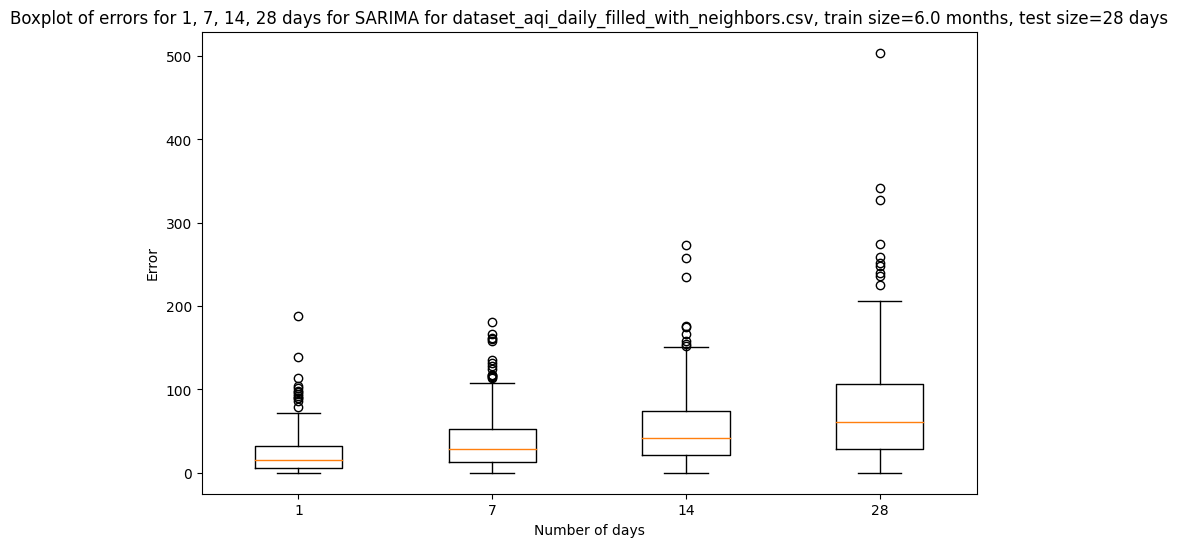


Results for dataset_aqi_hourly_filled_with_neighbors.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 27.326553101710083
RMSE: 39.17011350681942
R2: 0.584952780662408
SMAPE: 34.27149971110217
Errors for 7 days:
MAE: 45.766490227194915
RMSE: 60.99370219008377
R2: -0.09063235434184613
SMAPE: 64.55983826123946
Errors for 14 days:
MAE: 62.803579824531894
RMSE: 85.23788036404056
R2: -0.9833642112641221
SMAPE: 87.59239420747747
Errors for 28 days:
MAE: 101.69921289454732
RMSE: 132.32208766420587
R2: -4.074530789423344
SMAPE: 115.4692736686849


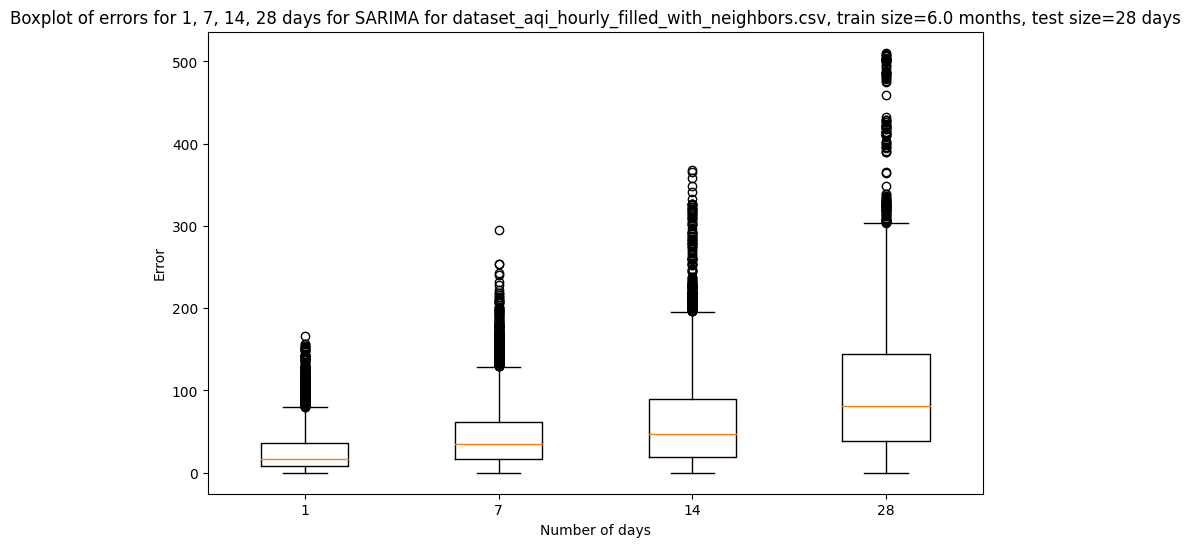

In [4]:
df_results = pd.read_csv(results_file_path)

# convert to datetime
df_results['DateTime of experiment'] = pd.to_datetime(df_results['DateTime of experiment'])
df_results['Training data from'] = pd.to_datetime(df_results['Training data from'])
df_results['Training data to'] = pd.to_datetime(df_results['Training data to'])
df_results['Testing data from'] = pd.to_datetime(df_results['Testing data from'])
df_results['Testing data to'] = pd.to_datetime(df_results['Testing data to'])
# convert Test Data and Test Predictions to lists of doubles
df_results['Test Data'] = df_results['Test Data'].apply(lambda x: json.loads(x))
df_results['Test Predictions'] = df_results['Test Predictions'].apply(lambda x: json.loads(x))
# calculate time delta in months round to 0 decimals
df_results['Training Duration'] = ((df_results['Training data to'] - df_results['Training data from']) / np.timedelta64(1, 'M')).round(0).astype(int)
df_results['Testing duration'] = ((df_results['Testing data to'] - df_results['Testing data from']) / np.timedelta64(1, 'D')).round(0).astype(int)

for experiment_case in experiment_cases:
    filename = experiment_case['filename']
    label = experiment_case['label']
    train_size = experiment_case['train_size']
    test_sizes = experiment_case['test_sizes']

    print(f'\nResults for {filename} with label {label}, train_size={train_size} months, test_size={test_sizes[0]} days:\n')

    df_results_filtered = df_results[(df_results['Dataset used'] == filename) & (df_results['Label predicted'] == label) & (df_results['Training Duration'] == train_size) & (df_results['Testing duration'] == test_sizes[0])]

    # Columns that contain list of predictions for each experiment
    tests_column = df_results_filtered['Test Data']
    predictions_column = df_results_filtered['Test Predictions']

    test_data_for_periods = []
    prediction_data_for_periods = []

    # Calculating errors for 1, 7, 14, 28 days and plotting forecast plot and boxplot
    for i in [1, 7, 14, 28]:
        # take i-1-th (-1 because enumerations starts from 0) element from each list of tests and predictions columns
        if 'daily' in filename:
            tests = tests_column.apply(lambda x: x[i-1])
            predictions = predictions_column.apply(lambda x: x[i-1])
        elif 'hourly' in filename:
            tests = pd.Series([item for sublist in tests_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])
            predictions = pd.Series([item for sublist in predictions_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])

        test_data_for_periods.append(tests)
        prediction_data_for_periods.append(predictions)

        # Calculate errors
        mae = mean_absolute_error(tests, predictions)
        rmse = np.sqrt(mean_squared_error(tests, predictions))
        r2 = r2_score(tests, predictions)
        smape = calculate_smape(tests, predictions)

        print(f'Errors for {i} days:')
        print(f'MAE: {mae}')
        print(f'RMSE: {rmse}')
        print(f'R2: {r2}')
        print(f'SMAPE: {smape}')

    # Plot boxplot of errors as error = abs(predictions - tests) for 1, 7, 14, 28 days on one plot where x label shows number of days
    plt.figure(figsize=(10,6))
    plt.boxplot([abs(test_data_for_periods[0] - prediction_data_for_periods[0]), abs(test_data_for_periods[1] - prediction_data_for_periods[1]), abs(test_data_for_periods[2] - prediction_data_for_periods[2]), abs(test_data_for_periods[3] - prediction_data_for_periods[3])])
    plt.xticks([1, 2, 3, 4], [1, 7, 14, 28])
    plt.xlabel('Number of days')
    plt.ylabel('Error')
    plt.title(f'Boxplot of errors for 1, 7, 14, 28 days for Fourier-ARIMA for {filename}, train size={train_size} months, test size={test_sizes[0]} days')
    plt.show()

# Trials

RMSE: 11.270351770088132


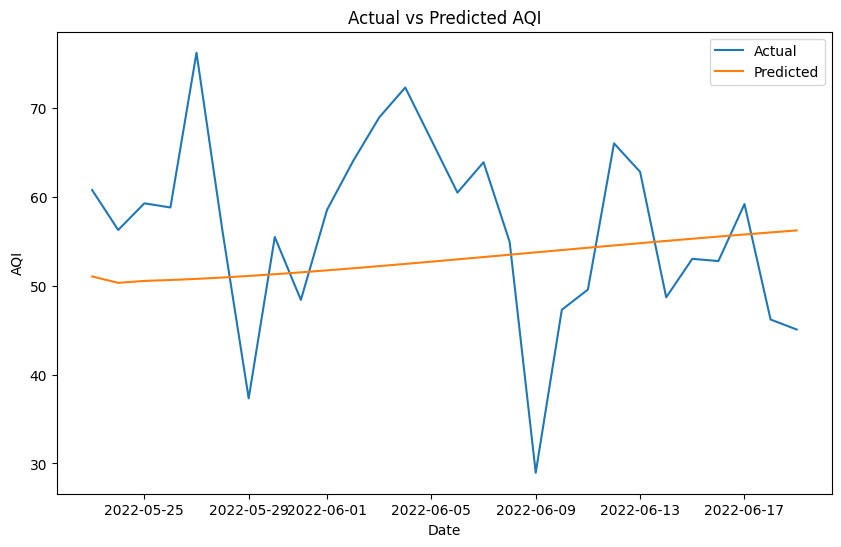

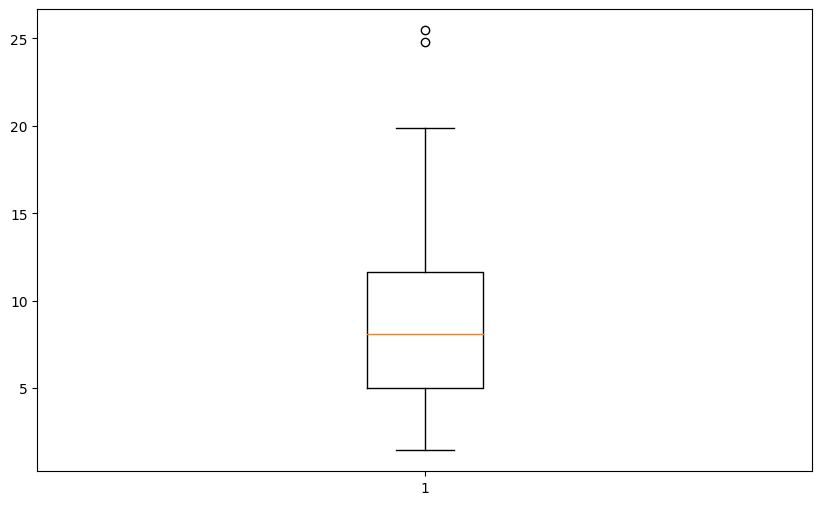

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.preprocessing import FourierFeaturizer
from sklearn.pipeline import Pipeline

df = pd.read_csv('Dataset/dataset_aqi_daily.csv')
df.DateTime = pd.to_datetime(df.DateTime)

train_data, test_data, start_date, slice_date, end_date = split_data(df, 0, 4*12, 28)

m=365
# Fourier transform
fourier_featurizer = FourierFeaturizer(m, 2)
y_train_transformed, x_train_transformed = fourier_featurizer.fit_transform(train_data.AQI.values.reshape(-1,1))


order = (1,0,3)
seasonal_order = (0,0,0,0)
model = ARIMA(y_train_transformed, exog=x_train_transformed, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

y_test_transformed, x_test_transformed = fourier_featurizer.transform(test_data.AQI.values.reshape(-1,1), n_periods=28)
# Forecast
forecast = model_fit.forecast(steps=28, exog=x_test_transformed)

RMSE = np.sqrt(mean_squared_error(y_test_transformed, forecast))
print(f'RMSE: {RMSE}')
# RMSE for m,1: 16.92226012105835
# RMSE for m,2: 11.270351770088132
# RMSE for m,4: 14.668141889829059

plt.figure(figsize=(10,6))
plt.plot(test_data.DateTime, test_data.AQI, label='Actual')
plt.plot(test_data.DateTime, forecast, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI')
plt.show()

plot_boxplot(test_data.AQI, forecast)

# import pmdarima as pm

# model = pm.auto_arima(y_train_transformed, exogenous=x_train_transformed, stationary=False, seasonal=False, trace=True, stepwise=True)

# order = model.get_params()['order']
# seasonal_order = model.get_params()['seasonal_order']
# model = ARIMA(train_data.AQI, exog=x_train_transformed, order=order, seasonal_order=seasonal_order)
# model_fit = model.fit()

# y_test_transformed, x_test_transformed = fourier_featurizer.transform(test_data.AQI.values.reshape(-1,1), n_periods=28)
# # Forecast
# forecast = model_fit.forecast(steps=28, exog=x_test_transformed)


In [ ]:
df = pd.read_csv('Dataset/dataset_aqi_daily.csv')
df.DateTime = pd.to_datetime(df.DateTime)

train_data, test_data, start_date, slice_date, end_date = split_data(df, 0, 4*12, 28)

model = pm.auto_arima(train_data.AQI, stationary=False, seasonal=False, trace=True, stepwise=True)

order = model.get_params()['order']
seasonal_order = model.get_params()['seasonal_order']
model = ARIMA(train_data.AQI, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=28)

RMSE = np.sqrt(mean_squared_error(test_data.AQI, forecast))
print(f'RMSE: {RMSE}')
# RMSE: 13.705533109154393 ? Better than ARIMA with Fourier transform

plt.figure(figsize=(10,6))
plt.plot(test_data.DateTime, test_data.AQI, label='Actual')
plt.plot(test_data.DateTime, forecast, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI')
plt.show()

plot_boxplot(test_data.AQI, forecast)